In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import  layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

In [11]:
# Load the data from your .npz file
data = np.load('cifar-10.npz')  # replace with your .npz filename

# Extract the arrays from the file
# Make sure the keys match the ones in your .npz file
train_images = data['x_train']
train_labels = data['y_train']
test_images = data['x_test']
test_labels = data['y_test']

print("Dataset loaded successfully from .npz file.")
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")


Dataset loaded successfully from .npz file.
Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [12]:
print("Unique train labels:", np.unique(train_labels))

Unique train labels: [0 1 2 3 4 5 6 7 8 9]


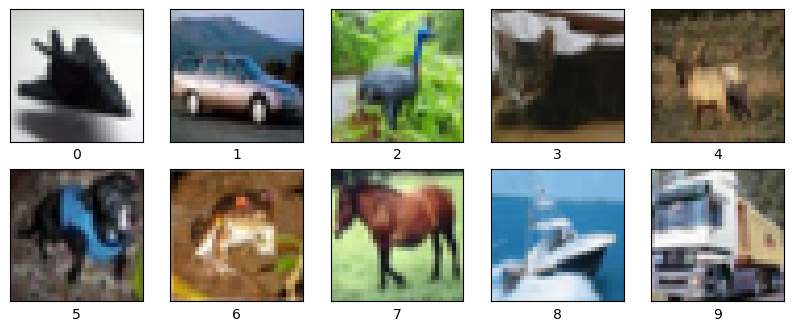

In [13]:
unique_labels = np.unique(train_labels)

# Display the first 10 unique images with their numeric labels
plt.figure(figsize=(10, 10))
for i in range(len(unique_labels)):  # In case there are fewer than 10 unique labels
    label = unique_labels[i]
    idx = np.where(train_labels == label)[0][0]  # Get the index of the first occurrence of this label
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[idx])  # Display image corresponding to this unique label
    plt.xlabel(label)  # Set the numeric label
plt.show()

In [14]:
# Maximum pixel value across train and test images
max_val = max(train_images.max(), test_images.max())

# Normalize images to range 0-1
train_images = train_images.astype('float32') / max_val
test_images  = test_images.astype('float32') / max_val


# One-hot encoding the labels
y_train_cat = to_categorical(train_labels, num_classes=10)
y_test_cat  = to_categorical(test_labels, num_classes=10)

# Matches the network’s softmax output ( probability distribution over 10 classes)
# One-hot encoding converts a class index into a binary vector of length num_classes
# Example with 10 classes:
# Label = 3 → [0,0,0,1,0,0,0,0,0,0]
# Label = 7 → [0,0,0,0,0,0,0,1,0,0]


print(f"Max value used for normalization: {max_val}")

Max value used for normalization: 255


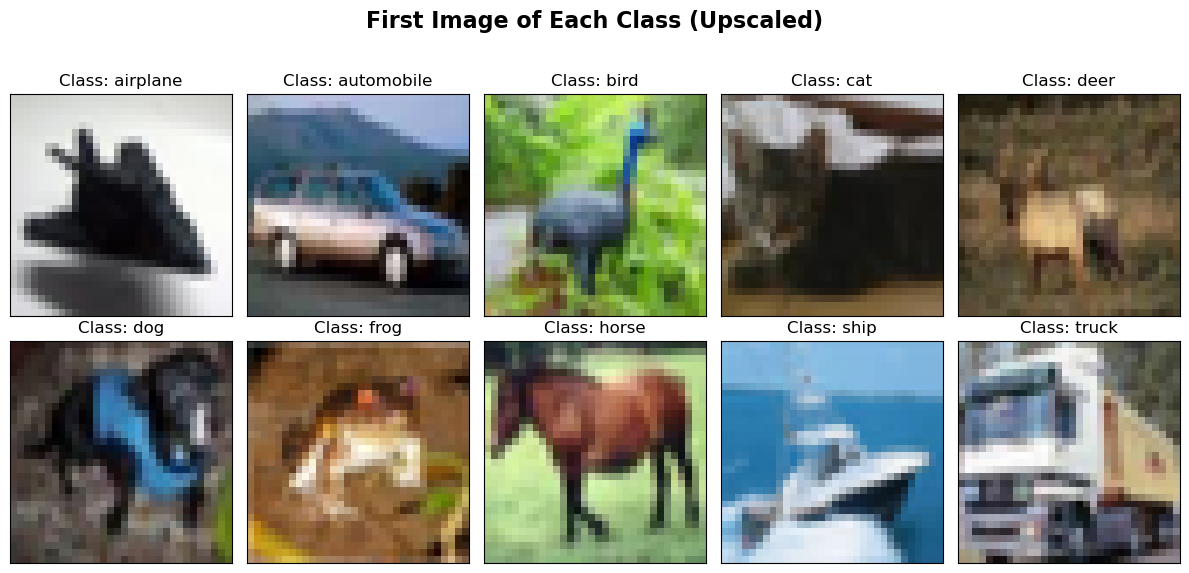

In [47]:
# Showing the train images

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

unique_labels = np.unique(train_labels)
plt.figure(figsize=(12, 6)) # Increased figure size for better viewing
plt.suptitle('First Image of Each Class (Upscaled)', fontsize=16, fontweight='bold')

for i, label in enumerate(unique_labels):
    # Find the index of the first image with this label
    index = np.where(train_labels == label)[0][0]
    
    plt.subplot(2, 5, i + 1)
    # Use interpolation='nearest' to upscale without blurring
    plt.imshow(train_images[index], interpolation='nearest') 
    plt.title(f"Class: {class_names[label]}", fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout for main title
plt.show() 

In [16]:
model = models.Sequential([
    # First convolution block
    # 32 filters
    # (3, 3) kernel size
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second convolution block
    # 64 filters
    layers.Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    # (2, 2) kernel size
    layers.MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third convolution block
    # 64 filters
    layers.Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),

    # Flatten and dense layers
    layers.Flatten(),
    # 64 neurons
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer with softmax for multi class classification
])


model.summary()

C:\Users\rohit\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,210 (481.29 KB)

 Trainable params: 122,890 (480.04 KB)

 Non-trainable params: 320 (1.25 KB)

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Early Stopping
# Stop training early if validation loss doesn't improve for 3 consecutive epochs
early_stop = EarlyStopping(
    monitor='val_loss',  # use validation loss to decide when to stop
    patience=3, 
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_images, y_train_cat,
    validation_data=(test_images, y_test_cat),
    epochs=15,      # Training will stop early if no improvement
    callbacks=[early_stop],
    batch_size=64, # 64 images at a time
    verbose=1
)

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - accuracy: 0.4043 - loss: 1.7077 - val_accuracy: 0.4062 - val_loss: 1.9894
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.6027 - loss: 1.1218 - val_accuracy: 0.6235 - val_loss: 1.0619
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - accuracy: 0.6643 - loss: 0.9508 - val_accuracy: 0.6107 - val_loss: 1.1165
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - accuracy: 0.6988 - loss: 0.8545 - val_accuracy: 0.6151 - val_loss: 1.1675
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - accuracy: 0.7246 - loss: 0.7771 - val_accuracy: 0.6913 - val_loss: 0.9027
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.7448 - loss: 0.7247 - val_accuracy: 0.6523 - val_loss: 1.0444
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.7565 - loss: 0.6875 - val_accuracy: 0.7187 - val_loss: 0.8207
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.7704 - loss: 0.6521 - 

In [19]:
results = model.evaluate(train_images, y_train_cat)
train_loss = results[0]
train_acc = results[1]

print(f"Training Loss: {train_loss:.3f}")
print(f"Training Accuracy: {train_acc:.2f}")


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7959 - loss: 0.5824
Training Loss: 0.586
Training Accuracy: 0.79


In [20]:
# Evaluate the model on test data
results = model.evaluate(test_images, y_test_cat, verbose=0)
test_loss = results[0]
test_acc = results[1]

print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.2f}")


Test Loss: 0.821
Test Accuracy: 0.72


In [21]:
predicted_values = model.predict(test_images)

print("Shape of predicted values:", predicted_values.shape)
# one hot encoded output

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Shape of predicted values: (10000, 10)


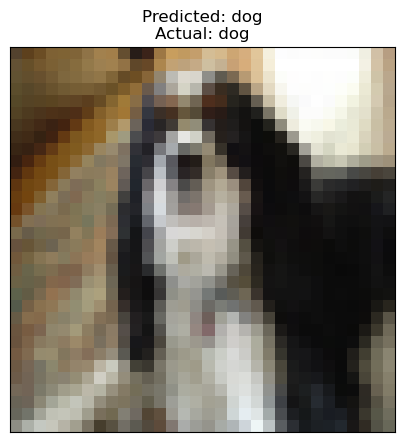

In [49]:
# Pick a random test image
n = random.randint(0, len(test_images)-1)

plt.figure(figsize=(5,5)) # Slightly larger figure for a better view
# Use interpolation='nearest' to display the pixels as larger blocks
plt.imshow(test_images[n], interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.grid(False)

# Get predicted and actual labels
predicted_label_index = np.argmax(predicted_values[n])
predicted_label = class_names[predicted_label_index]
actual_label = class_names[test_labels[n][0]]

plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}")

plt.show()

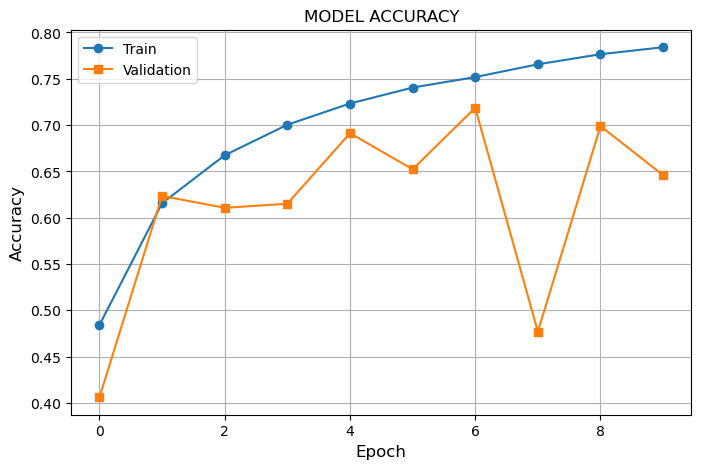

In [65]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='s')
plt.title('MODEL ACCURACY')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()